In [3]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [4]:
# Set the max_columns to be displayed to be 35, which is the number of columns in the data frame.
pd.options.display.max_columns = 60
pd.options.display.max_rows = 100

In [5]:
# Load the extracted features.
df_1998 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_1998_422.csv')
df_1999 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_1999_422.csv')
df_2003 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2003_422.csv')
df_2004 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2004_422.csv')
df_2005 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2005_422.csv')
df_2006 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2006_422.csv')
df_2007 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2007_422.csv')
df_2008 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2008_422.csv')
df_2009 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2009_422.csv')
df_2010 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2010_422.csv')
df_2011 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2011_422.csv')
df_2012 = pd.read_csv('/Users/richadeshmukh/Desktop/TEMP/Preproc_Data/AXBYA/audio_feature_axbya_2012_422.csv')

In [6]:
frames = [df_1998, df_1999, df_2003, df_2004, df_2005, df_2006, df_2007, 
          df_2008, df_2009, df_2010, df_2011, df_2012]
# Concatenate them into a big frame.
df = pd.concat(frames)

In [7]:
# Discard samples with NaN values.
df = df.dropna()

In [8]:
# Create dummy variables for vowel, add them to the data frame as new columns.
dummies_vowel = pd.get_dummies(df['vowel'], prefix= 'vowel')

In [9]:
# Drop features that are unnormalized or unhelpful.
df = df.drop(['vowel', 'speaker_id'], axis=1)

df = pd.concat([df, dummies_vowel], axis=1)

In [10]:
'''
Separate the dataframe into two dataframes, separately the one consisting of
neutral samples and the one consisting of male & female words.
'''
neutral_samples = df.loc[df['classify']==0]
data_set = df.loc[df['classify'] != 0]

In [11]:
print('There are ', neutral_samples.shape[0], ' neutral words.')

('There are ', 3822095, ' neutral words.')


In [12]:
# Separate further and get a dataframe of male words only and a dataframe of female words only.
female_samples = data_set.loc[data_set['classify']==-1]
male_samples = data_set.loc[data_set['classify']==1]

In [13]:
print('There are ', female_samples.shape[0], ' female words.')
print('There are ', male_samples.shape[0], ' male words.')

('There are ', 2402, ' female words.')
('There are ', 17960, ' male words.')


In [14]:
# Shuffle the data so that we are not always getting the samples from the early years.
female_samples = shuffle(female_samples)
male_samples = shuffle(male_samples)
neutral_samples = shuffle(neutral_samples)

In [15]:
# Obtain the training set of 1206 male words and 1206 female words.
train_set = pd.concat([female_samples.iloc[range(1206)], male_samples.iloc[range(1206)]])

In [16]:
# Obtain the validation set of 402 male words and 402 female words for searching hyperparameters.
val_set = pd.concat([female_samples.iloc[range(1206, 1608)], 
                     male_samples.iloc[range(1206, 1608)]])

# Obtain the test set of 402 male words and 402 female words for checking performance.
test_set = pd.concat([female_samples.iloc[range(1608, 2010)], 
                     male_samples.iloc[range(1608, 2010)]])

In [17]:
# Shuffle the train_set, val_set and test_set.
train_set = shuffle(train_set)
val_set = shuffle(val_set)
test_set = shuffle(test_set)

In [18]:
# As we've finished shuffling, get train_set, test_set and val_set
# with features indicating identity dropped.
train_set_dropped = train_set.drop(['docket_id', 'text', 'speaker_name'], 
                                   axis=1)
val_set_dropped = val_set.drop(['docket_id', 'text', 'speaker_name'], 
                               axis=1)
test_set_dropped = test_set.drop(['docket_id', 'text', 'speaker_name'], 
                                 axis=1)

In [19]:
# Process and get X_train, y_train, x_val, y_val, x_test, y_test
y_train = train_set_dropped[['classify']]
x_train = train_set_dropped.drop(['classify'], axis=1)
y_val = val_set_dropped[['classify']]
x_val = val_set_dropped.drop(['classify'], axis=1)
y_test = test_set_dropped[['classify']]
x_test = test_set_dropped.drop(['classify'], axis=1)

In [20]:
# List of features involved in modeling.
predictors = list(x_train.columns)

In [21]:
# Convert data frames into numpy ndarrays.
y_train = y_train.values
x_train = x_train.values

y_val = y_val.values
x_val = x_val.values

y_test = y_test.values
x_test = x_test.values

# Adjust the shape of the labels.
y_train = y_train.reshape(y_train.shape[0],)
y_val = y_val.reshape(y_val.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

In [22]:
model = RandomForestClassifier()

# Set the grid of parameters among which we will search for hyperparameters.
param_grid = {"max_depth": [30, 50, 70, 100, None],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators": [100],
              "criterion": ['gini', 'entropy']}

clf = GridSearchCV(model, param_grid=param_grid)

In [23]:
clf.fit(x_val, y_val)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3, 10], 'n_estimators': [100], 'criterion': ['gini', 'entropy'], 'max_depth': [30, 50, 70, 100, None], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [25]:
model = RandomForestClassifier(criterion = 'entropy', max_depth = 70, min_samples_leaf = 1,
 min_samples_split = 3, n_estimators = 100)

In [26]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# The accuracy of prediction on the training set.
model.score(x_train, y_train)

1.0

In [28]:
# Without a consideration of margin, the accuracy of the prediction on the test set.
model.score(x_test, y_test)

0.76865671641791045

In [29]:
y_test_pred = model.predict(x_test)

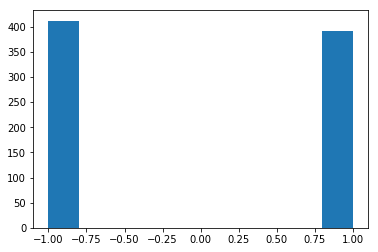

In [30]:
# Have a general idea of the distribution of prediction.
plt.hist(y_test_pred)

plt.show()

In [31]:
# Ranking of features with respect to their importance.
features = pd.DataFrame()
features['feature'] = predictors
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'],ascending=False)

,feature,importance
8,f1@20%_n,0.069291
1,t_n,0.058978
13,f2@20%_n,0.054383
4,f3_n,0.053668
6,B2_n,0.053537
5,B1_n,0.053148
9,f1@35%_n,0.052624
17,f2@80%_n,0.050102
14,f2@35%_n,0.049990
16,f2@60%_n,0.049551


In [33]:
female_samples = data_set.loc[data_set['classify']==-1]
female_samples_vowel_IH = female_samples.loc[female_samples['vowel_IH']==1]
print(female_samples_vowel_IH.shape[0]*1.0/female_samples.shape[0])

0.00707743547044


In [34]:
male_samples = data_set.loc[data_set['classify']==1]
male_samples_vowel_IH = male_samples.loc[male_samples['vowel_IH']==1]
print(male_samples_vowel_IH.shape[0]*1.0/male_samples.shape[0])

0.129510022272


In [35]:
# Test on neutral words.
neutral_samples_dropped = neutral_samples.drop(['docket_id', 
                                                'speaker_name', 'text'], 
                                               axis=1)

y_neutral = neutral_samples_dropped[['classify']]
x_neutral = neutral_samples_dropped.drop(['classify'], axis=1)
y_neutral = y_neutral.values
x_neutral = x_neutral.values

y_neutral = y_neutral.reshape(y_neutral.shape[0],)

In [36]:
neutral_predict_proba = model.predict_proba(x_neutral)

In [37]:
model.classes_

array([-1.,  1.])

In [38]:
numOfMale = neutral_predict_proba[neutral_predict_proba[:,1]>0.75].shape[0]

In [39]:
numOfFemale = neutral_predict_proba[neutral_predict_proba[:,0]>0.75].shape[0]

In [40]:
totalNeutralWords = neutral_predict_proba.shape[0]

In [41]:
(numOfMale+numOfFemale)*1.0/totalNeutralWords

0.20386123317185995

In [42]:
(numOfFemale)*1.0/(numOfFemale+numOfMale)

0.4012554272007516

In [43]:
result = pd.DataFrame()
result['docket_id'] = neutral_samples['docket_id']
result['text'] = neutral_samples['text']
result['probability_of_male'] = neutral_predict_proba[:,1]
result['probability_of_female'] = neutral_predict_proba[:, 0]

In [44]:
result.sort_values(by=['probability_of_male'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
61270,2008_07_1209,PARTICULARITY,1.000000,0.000000
181431,2012_12_236,POSITIVE,1.000000,0.000000
15396,1999_8_orig,FIFTEEN,1.000000,0.000000
52479,2010_09_1298,IN,1.000000,0.000000
64036,2012_11_207,CRITICAL,1.000000,0.000000
65217,2009_08_1553,SPECIFICALLY,1.000000,0.000000
56462,2004_03_1237,PRACTICE,1.000000,0.000000
766302,2008_08_479,ADMINISTRATOR,1.000000,0.000000
66338,2009_08_1553,BRINGS,1.000000,0.000000
6553,2009_07_11191,CERTIFICATES,1.000000,0.000000


In [45]:
result.sort_values(by=['probability_of_female'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
537889,2008_07_901,PUNISHMENT,0.000000,1.000000
329631,1999_98_1856,FULLY,0.000000,1.000000
99118,1999_98_1161,FULLY,0.000000,1.000000
228481,2011_11_210,BUS,0.000000,1.000000
100343,1998_98_369,FULLY,0.000000,1.000000
537819,2008_07_901,PUNISHMENT,0.000000,1.000000
23006,2004_03_10198,HUNDRED,0.000000,1.000000
537716,2008_07_901,PUNISHMENT,0.000000,1.000000
95891,1998_98_369,FUNCTION,0.000000,1.000000
183547,2010_10_188,OTHER,0.000000,1.000000


In [46]:
neutral_predict_proba

array([[ 0.415     ,  0.585     ],
       [ 0.64166667,  0.35833333],
       [ 0.665     ,  0.335     ],
       ..., 
       [ 0.40333333,  0.59666667],
       [ 0.555     ,  0.445     ],
       [ 0.75833333,  0.24166667]])

In [47]:
AXBYA_neutral_withvowel = pd.DataFrame.copy(neutral_samples)
AXBYA_neutral_withvowel.loc[neutral_predict_proba[:,1]>0.75, 'classify']=1
AXBYA_neutral_withvowel.loc[neutral_predict_proba[:,0]>0.75, 'classify']=-1
AXBYA_neutral_withvowel['probability_of_male'] = neutral_predict_proba[:,1]
AXBYA_neutral_withvowel['probability_of_female'] = neutral_predict_proba[:, 0]

In [49]:
df_to_save = AXBYA_neutral_withvowel.copy()
df_to_save = df_to_save.loc[:,['speaker_name', 'docket_id', 'text', 'classify', 'probability_of_male',
                                'probability_of_female']]

In [50]:
df_to_save.to_csv('AXBYA_neutral_withvowel.csv', index=False)

In [51]:
test = pd.read_csv('AXBYA_neutral_withvowel.csv')

In [52]:
#Throw away vowel dummy variables

In [53]:
# Get a list of vowel dummy variables
vowel_predictors = []
for e in list(df.columns.values):
    if e[:5] == 'vowel':
        vowel_predictors.append(e)

In [54]:
# Set up for testing without vowel.
x_train_without_vowel = train_set_dropped.drop(['classify'], axis=1)
x_train_without_vowel = x_train_without_vowel.drop(vowel_predictors, axis=1)
predictors_without_vowel = list(x_train_without_vowel.columns)
x_train_without_vowel = x_train_without_vowel.values
y_train_without_vowel = y_train
x_val_without_vowel = val_set_dropped.drop(['classify'], axis=1)
x_val_without_vowel = x_val_without_vowel.drop(vowel_predictors, axis=1).values
y_val_without_vowel = y_val
x_test_without_vowel = test_set_dropped.drop(['classify'], axis=1)
x_test_without_vowel = x_test_without_vowel.drop(vowel_predictors, axis=1).values
y_test_without_vowel = y_test
x_neutral_without_vowel = neutral_samples_dropped.drop(['classify'], axis=1)
x_neutral_without_vowel = x_neutral_without_vowel.drop(vowel_predictors, axis=1).values
y_neutral_without_vowel = y_neutral

In [55]:
model2 = RandomForestClassifier()

# Set the grid of parameters among which we will search for hyperparameters.
param_grid = {"max_depth": [30, 50, 70, 100, None],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators": [100],
              "criterion": ['gini', 'entropy']}

clf2 = GridSearchCV(model2, param_grid=param_grid)

In [56]:
clf2.fit(x_val_without_vowel, y_val_without_vowel)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3, 10], 'n_estimators': [100], 'criterion': ['gini', 'entropy'], 'max_depth': [30, 50, 70, 100, None], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
clf2.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [58]:
model_without_vowel = RandomForestClassifier(criterion = 'entropy', max_depth=100, min_samples_split=10, 
                              min_samples_leaf=1, n_estimators=100)
model_without_vowel.fit(x_train_without_vowel, y_train_without_vowel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
model_without_vowel.score(x_train_without_vowel, y_train_without_vowel)

0.99668325041459371

In [60]:
model_without_vowel.score(x_test_without_vowel, y_test_without_vowel)

0.73756218905472637

In [61]:
y_test_pred_without_vowel = model_without_vowel.predict(x_test_without_vowel)

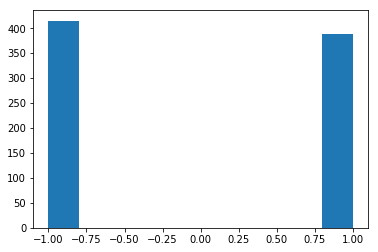

In [62]:
# Have a general idea of the distribution of prediction.
plt.hist(y_test_pred_without_vowel)

plt.show()

In [63]:
# Ranking of features with respect to their importance.
features_without_vowel = pd.DataFrame()
features_without_vowel['feature'] = predictors_without_vowel
features_without_vowel['importance'] = model_without_vowel.feature_importances_
features_without_vowel.sort_values(by=['importance'],ascending=False)

,feature,importance
8,f1@20%_n,0.083848
13,f2@20%_n,0.065575
1,t_n,0.064451
6,B2_n,0.061823
9,f1@35%_n,0.059011
5,B1_n,0.057896
2,f1_n,0.056369
4,f3_n,0.055026
17,f2@80%_n,0.053670
14,f2@35%_n,0.052920


In [64]:
# Test on neutral words.
neutral_predict_without_vowel = model_without_vowel.predict_proba(x_neutral_without_vowel)

In [65]:
model_without_vowel.classes_

array([-1.,  1.])

In [66]:
numOfFemale_without_vowel = neutral_predict_without_vowel[abs(neutral_predict_without_vowel[:,0])>0.75].shape[0]
numOfMale_without_vowel = neutral_predict_without_vowel[abs(neutral_predict_without_vowel[:,1])>0.75].shape[0]

In [67]:
(numOfFemale_without_vowel+numOfMale_without_vowel)*1.0/totalNeutralWords

0.0618323197094787

In [68]:
numOfFemale_without_vowel*1.0/(numOfMale_without_vowel+numOfFemale_without_vowel)

0.6782155385077583

In [69]:
result2 = pd.DataFrame()
result2['docket_id'] = neutral_samples['docket_id']
result2['text'] = neutral_samples['text']
result2['probability_of_male'] = neutral_predict_without_vowel[:,1]
result2['probability_of_female'] = neutral_predict_without_vowel[:, 0]

In [70]:
result2.sort_values(by=['probability_of_male'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
123784,2011_10_6549,YEAR,0.948326,0.051674
160165,2006_05_9264,INHERENT,0.945382,0.054618
22237,1999_98_1037,HERE,0.942643,0.057357
264942,2004_03_9685,HERE,0.942241,0.057759
264866,2004_03_9685,HERE,0.942241,0.057759
380271,2004_04_637,GIVES,0.941232,0.058768
380399,2004_04_637,GIVES,0.941232,0.058768
72194,2003_02_1824,GIVEN,0.940387,0.059613
179235,2007_07_320,HERE,0.939828,0.060172
23646,2010_09_1088,YOU,0.939335,0.060665


In [71]:
result2.sort_values(by=['probability_of_female'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
196627,2010_10_238,MONEY,0.006927,0.993073
15648,2009_08_1008,UNJUST,0.009333,0.990667
15760,2009_08_1008,UNJUST,0.009333,0.990667
39983,2010_09_1272,UNREASONABLE,0.009524,0.990476
70445,2011_10_1399,MONEY,0.012500,0.987500
70364,2011_10_1399,MONEY,0.012500,0.987500
70519,2011_10_1399,MONEY,0.012500,0.987500
70866,2011_10_1399,MONEY,0.013167,0.986833
70777,2011_10_1399,MONEY,0.013167,0.986833
70960,2011_10_1399,MONEY,0.013167,0.986833


In [72]:
AXBYA_neutral_withoutvowel = pd.DataFrame.copy(neutral_samples)
AXBYA_neutral_withoutvowel.loc[neutral_predict_without_vowel[:,1]>0.75, 'classify']=1
AXBYA_neutral_withoutvowel.loc[neutral_predict_without_vowel[:,0]>0.75, 'classify']=-1
AXBYA_neutral_withoutvowel['probability_of_male'] = neutral_predict_without_vowel[:,1]
AXBYA_neutral_withoutvowel['probability_of_female'] = neutral_predict_without_vowel[:, 0]

In [73]:
AXBYA_neutral_withoutvowel.to_csv('AXBYA_neutral_withoutvowel.csv')